### Remove Unwanted Runtime Warnings and Import Neccessary Libraries

In [1]:
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from num2words import num2words
import spacy
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore') # Removes the warnings about deprecated features and such 

ModuleNotFoundError: No module named 'sentence_transformers'

### Preprocessing Image Labels and Aggregating Data

In this cell we perform the starting stages of the data transformations required to have the labels ready for machine learning tasks. Here's the general process:

1. We extract the image labels from the ImageLabels excel file and use the relevant columns in a pandas dataframe. 

2. We only keep the labels that have a confidence score of > 70%. This can be changed, but this value appears to work fairly well with our models.

3. The labels for a given image are joined together by the image name, displayed as a list containing the 'instance count' + 'object name / label'. Note that we remove any special characters along the way as this can affect the model's performance.

In [ ]:
import re

# Define the base directory
BASE_DIR = 'Example Data-20240208T214429Z-001/Example Data'

df = pd.read_excel(f'{BASE_DIR}/ImageLabels.xlsx', usecols=['Image Name', 'Confidence', 'Instance Count', 'Label'])

# Filter based on the criteria
filtered_df = df[(df['Confidence'] >= 70)]

# Append the instance counts to the label, e.g: '1 Human'
filtered_df['Labels'] = filtered_df['Instance Count'].astype(str) + ' ' + filtered_df['Label'].str.lower() # convert all the values to lowercase --> we're using BERT uncased so this is important

# Removing potentially unwanted characters from the labels (emojis as an example) for processing
pattern = r'[^\w\s]' # simple regex that only keeps alphanumeric values

# Use regex substitution to remove special characters from the 'text' column
filtered_df['Labels'] = filtered_df['Labels'].apply(lambda x: re.sub(pattern, '', x))

# Aggregate labels for each image
aggregated_labels = filtered_df.groupby('Image Name')['Labels'].apply(lambda x: ', '.join(x)).reset_index()

# Display the aggregated dataframe
aggregated_labels.head()

,Image Name,Labels
0,(1) 18380579401063495.JPG,1 motor bike
1,(1) @GreyCupFestival - 109th Grey Cup.jpeg,"2 adult, 1 female, 7 person, 1 woman, 1 male, ..."
2,(10) 17887803224903630.jpeg,"0 animal, 1 horse, 0 horseback riding, 0 leisu..."
3,(12) 17985809330117499.jpeg,"0 fun, 0 vacation, 1 person, 0 road trip, 1 he..."
4,(13) 18013990822817757.jpeg,"0 clothing, 0 coat, 0 jacket, 0 vest, 0 shirt,..."


### Creating a Dictionary of Image Labels

This cell converts the aggregated data frame into a dictionary where each key is an `Image Name` and each value is a list of associated `Labels`. This structure facilitates easier access and manipulation of the labels associated with each image. This is followed by displaying the first five entries of the dictionary to verify its structure and contents. Here's a step-by-step breakdown of the function's logic:

1. **Splitting the Label String**: Each label string is split by ', ' into individual 'number item' parts.

2. **Processing Each Part**: For each part, it splits again on the first space to separate the number from the item. The number is converted from a string to an integer.

3. **Transformation Logic**:
   - If the number is 0, we omit the number and append only the item name to the list of transformed parts. This handles the case where a label indicates the absence of an object (e.g., '0 clothing' becomes 'clothing').
   - For numbers greater than 0, it converts the number into its word form using `num2words` (e.g., '1' becomes 'one'). It then checks if the number is greater than 1 for pluralization. If so, and if the item name does not already end in 's', it adds 's' to make the item name plural.

4. **Joining Transformed Parts**: The transformed parts are then joined back together into a single string with ', ' as the separator, resulting in a human-readable label string.

5. **Applying the Transformation**: This function is applied to each label in the 'Labels' column of the `aggregated_labels` DataFrame, creating a new column 'transformed labels' with the processed labels.

6. **Creating a Dictionary**: The DataFrame is then converted into a dictionary where the keys are the image names from the 'Image Name' column, and the values are the transformed labels. This makes it easy to look up the labels for an image by its name.

7. **Extracting Image Names**: Finally, the name of all the images are extracted into a list for easy data manipulation (especially for plotting).

This process will make it easier for the NLP models to understand the label text

In [ ]:
def transform_label(label):
    parts = label.split(', ')
    transformed_parts = []
    
    for part in parts:
        number, item = part.split(' ', 1) # extract the numerical value, followed by the object of the label
        number = int(number)

        # Convert to ordinal, remove '0', and pluralize
        if number == 0:
            transformed_parts.append(item)  # Zero case
        else:
            ordinal = num2words(number)
            if number > 1:
                if not item.endswith('s'):  # Simple pluralization rule
                    item += 's'
            transformed_parts.append(f"{ordinal} {item}")
    return ', '.join(transformed_parts)

# Apply transformation to the 'labels' column
# LABELS_PREFIX = 'An image containing ' # Change as you want, this was added in the hopes of enhancing model performance, but is not required.
aggregated_labels['transformed labels'] = aggregated_labels['Labels'].apply(transform_label)

# Convert the DataFrame into a dictionary
labels_dict = pd.Series(aggregated_labels['transformed labels'].values,index=aggregated_labels['Image Name']).to_dict()

# Extract the name of all the images in the folder into a list
image_names = aggregated_labels['Image Name'].tolist()


### Preparing Text Data for Embedding Generation

In this cell, we prepare text data for generating embeddings, a crucial step for natural language processing tasks that require numerical representations of text. The process is outlined as follows:

1. Initialization of Text Variables: We start by defining two text examples, user_text_prompt and smart_story_description, which represent different types of text inputs that we'll be working with. These examples could be used to simulate input from a user or a description generated by an application.

2. Conversion of Label Dictionaries: The labels_dict variable, assumed to be defined earlier, contains labels associated with images. We transform this dictionary into a list of strings, where each string contains the concatenated labels for a single image.

3. Aggregation of All Texts: To prepare for embedding (with the BERT model, not spaCy) -  we aggregate all texts that need to be encoded into a single list. This includes our predefined text examples (user_text_prompt and smart_story_description) and the texts derived from image labels. 

In [ ]:
# Initialize user_text_prompt and smart_story_descriptions are provided as examples
user_text_prompt = "My favorite animal is horses. Horseback riding is fun!"
smart_story_description = "A building with magnificient architecture"
# First, convert the labels dictionary into a single string per image
labels_texts = [''.join(labels) for labels in labels_dict.values()]
# Combine all texts that need embeddings into a single list
texts_to_encode = [user_text_prompt, smart_story_description] + labels_texts

### Using spaCy model to calculate text similarity

This cell loads a the large version of the spaCy model to process the text prompt and smart story description, converting them to spaCy's document format. 

1. The model calculates and compares the semantic similarity between these texts and the labels of various images, assumed to be stored in `labels_dict`. The similarities are calculated for both the user text prompt and the smart story description against each image label, resulting in two lists of similarity scores. 

2. The scores are then visualized, displaying a bar chart with separate bars for the similarities from the user text and the story description to the image labels, allowing for a visual comparison of how semantically similar the user's text and the story description are to the labels of the images.

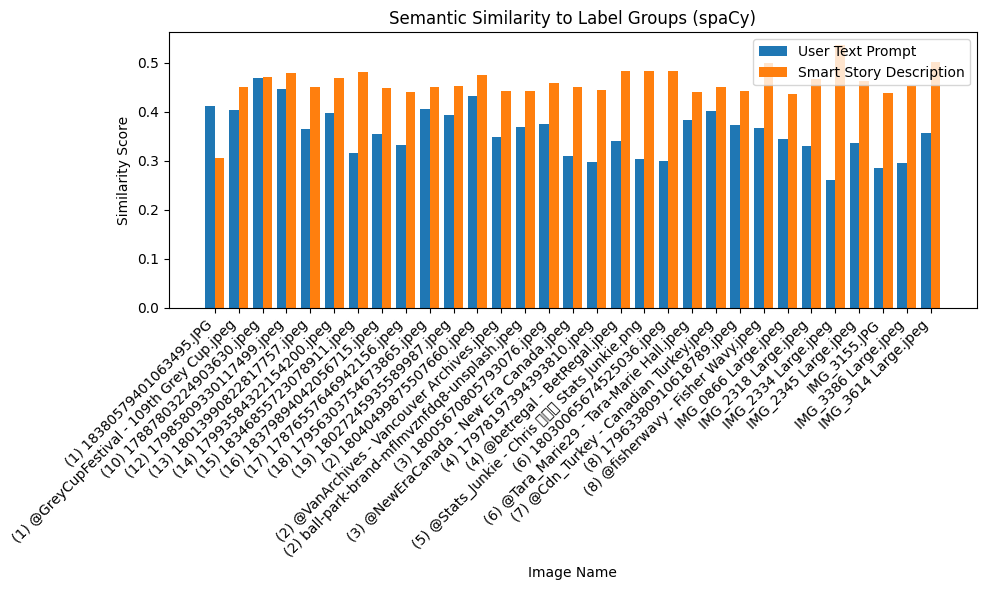

In [ ]:
nlp = spacy.load("en_core_web_lg")

text_prompt_nlp = nlp(user_text_prompt)
smart_story_desc_nlp = nlp(smart_story_description)

# Assuming 'labels_dict' is your existing dictionary
user_similarities_spaCy = []
story_similarities_spaCy = []

# Calculate similarities
for name in image_names:
    label_nlp = nlp(labels_dict[name])
    user_similarities_spaCy.append(text_prompt_nlp.similarity(label_nlp))
    story_similarities_spaCy.append(smart_story_desc_nlp.similarity(label_nlp))

# Plotting the similarities
plt.figure(figsize=(10, 6))
index = range(len(image_names))
plt.bar(index, user_similarities_spaCy, width=0.4, label='User Text Prompt')
plt.bar([i+0.4 for i in index], story_similarities_spaCy, width=0.4, label='Smart Story Description')
plt.xlabel('Image Name')
plt.ylabel('Similarity Score')
plt.xticks([i+0.2 for i in index], image_names, rotation=45, ha='right')
plt.legend()
plt.title('Semantic Similarity to Label Groups (spaCy)')
plt.tight_layout()
plt.show()

### Using Sentence Transformer (all-MiniLM-L6-v2) to calculate text similarity

Here we initialize the Sentence Transformer model 'all-MiniLM-L6-v2' to encode the user text prompt, smart story description, and the transformed image labels.

1. The model extracts embeddings for the user prompt and story description separately from those of the image labels. Using these embeddings, we calculate the cosine similarities between the prompt (and story) embeddings against each label embedding, generating similarity scores for both user and story contexts. Same process as the last model, but fairly different results to the nature of the comparison from the models. Having both gives a more balanced view of the actual semantic correlation between the input text and labels.

2. The scores are then visualized using a bar chart, showcasing the semantic similarity of each text to the labels (same as before).

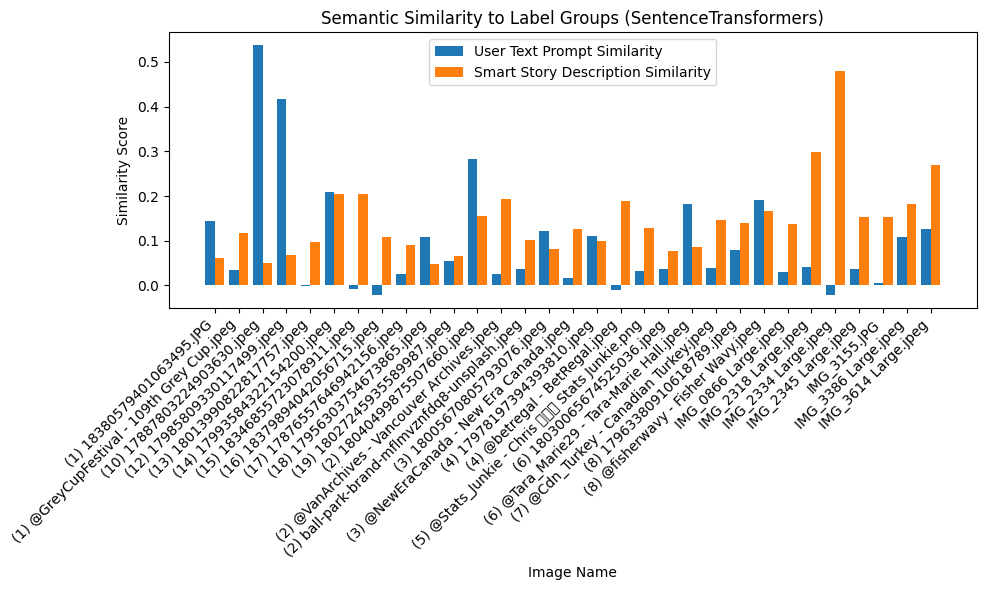

In [ ]:
# Initialize tokenizer and model once
# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

encoded_texts = model.encode(texts_to_encode)

# Extract embeddings for prompts and labels
prompt_embedding = encoded_texts[0]
story_embedding = encoded_texts[1]
label_embeddings = encoded_texts[2:]

# Calculate cosine similarities
user_similarities_st = []
story_similarities_st = []
for label_embedding in label_embeddings:
    user_similarities_st.append(cosine_similarity([prompt_embedding], [label_embedding])[0][0])
    story_similarities_st.append(cosine_similarity([story_embedding], [label_embedding])[0][0])

# Plotting the similarities
plt.figure(figsize=(10, 6))
index = range(len(labels_texts))
plt.bar(index, user_similarities_st, width=0.4, label='User Text Prompt Similarity')
plt.bar([i+0.4 for i in index], story_similarities_st, width=0.4, label='Smart Story Description Similarity')
plt.xlabel('Image Name')
plt.ylabel('Similarity Score')
plt.xticks([i+0.2 for i in index], image_names, rotation=45, ha='right')
plt.legend()
plt.title('Semantic Similarity to Label Groups (SentenceTransformers)')
plt.tight_layout()
plt.show()

### Calculating and Plotting Weighted Mean Similarity Scores Based on Model Outputs

Here we calculate and plot the weighted mean similarities of user texts and story descriptions based on the outputs from two different models: spaCy and Sentence Transformer. The aim is to assign a weighted importance to each model's similarity outputs and visualize the comparisons.

#### Calculating Weighted Mean Similarities

Weights are defined for the outputs from the spaCy and Sentence Transformer models, with spaCy currently being given a weight of 65% and Sentence Transformer 35%. These weights are completely up to user preference, but are currently set at these values based off testing.

A loop iterates through the names of images, calculating the weighted mean similarity for each name, both for user texts and story descriptions, using the predefined weights. These calculations are stored in the respective dictionaries.

#### Plotting

Both subplots display the mean similarity values as bar charts, with the names on the x-axis and mean similarity on the y-axis.


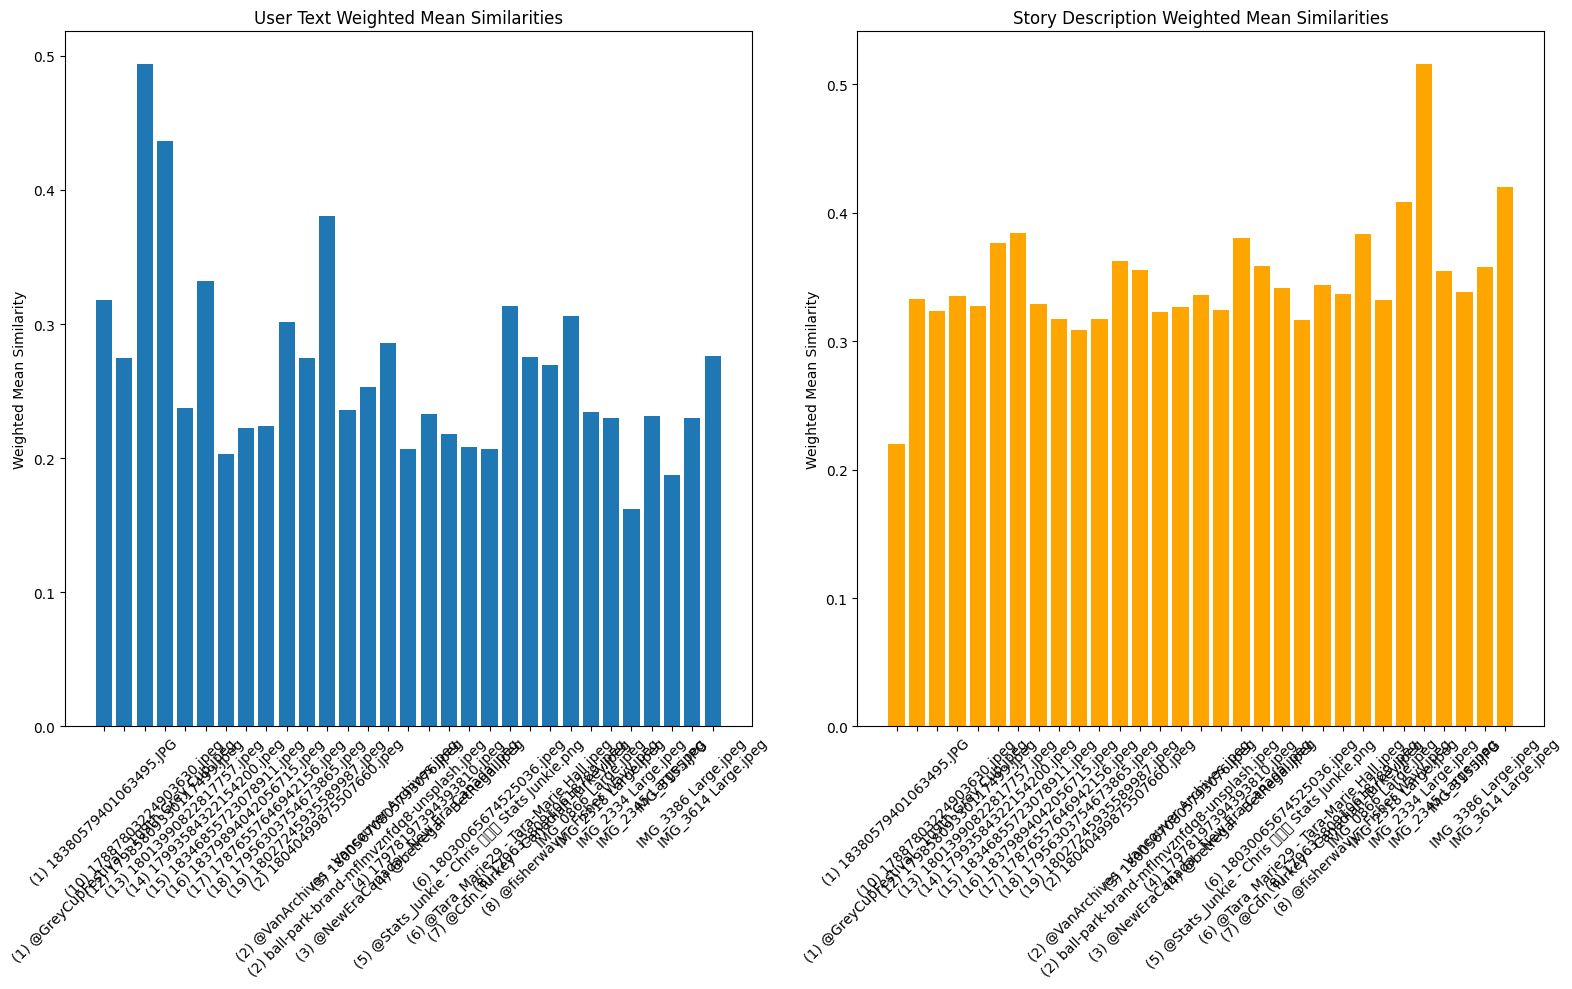

In [ ]:
# Calculating mean similarities
user_weighted_mean_similarities = {}
story_weighted_mean_similarities = {}

# Assigning weights (importance) to the outputs of each model. spaCy model weight: 65%, Sentence Transformer model weight: 35%
SPACY_WEIGHT = 0.65
SENTENCE_TRANSFORMER_WEIGHT = 0.35

for i, name in enumerate(image_names):
    user_weighted_mean_similarities[name] = (SPACY_WEIGHT * user_similarities_spaCy[i] + SENTENCE_TRANSFORMER_WEIGHT * user_similarities_st[i])
    story_weighted_mean_similarities[name] = (SPACY_WEIGHT * story_similarities_spaCy[i] + SENTENCE_TRANSFORMER_WEIGHT * story_similarities_st[i])

# User text mean similarities
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.bar(user_weighted_mean_similarities.keys(), user_weighted_mean_similarities.values())
plt.title('User Text Weighted Mean Similarities')
plt.ylabel('Weighted Mean Similarity')
plt.xticks(rotation=45)

# Story description mean similarities
plt.subplot(1, 2, 2)
plt.bar(story_weighted_mean_similarities.keys(), story_weighted_mean_similarities.values(), color='orange')
plt.title('Story Description Weighted Mean Similarities')
plt.ylabel('Weighted Mean Similarity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Establishing a 'warning' rule based off the weighted similarity score

Here we established a 40% similarity threshold to flag images as semantically unrelated to a smart story. This is subject to change, and will likely vary greatly depending on the quality of the labels, the number of labels, the content of the smart story or user input, etc. 

We build two pandas DataFrames for storing the similarity scores (from spaCy and Sentence Transformers) of user text prompts and smart story descriptions against image labels. Each DataFrame is augmented with a warning column to highlight scores falling below the threshold.

In [ ]:
# Defining an arbitrary threshold for images that receive a warning because they aren't semantically related enough to the smart story

WARNING_THRESHOLD = 0.40 # 40% threshold value for now, change as needed.

# Create a DataFrame for user text similarities
df_user = pd.DataFrame({
    "Image Name": image_names,
    "SpaCy Similarity": user_similarities_spaCy,
    "ST Similarity": user_similarities_st,
    "Weighted Mean Score": [user_weighted_mean_similarities[name] for name in image_names]
})

# Add a 'Warning' column based on the mean similarity score being less than 20%
df_user["Low Similarity Warning"] = df_user["Weighted Mean Score"] < WARNING_THRESHOLD

# Create a DataFrame for smart story similarities
df_story = pd.DataFrame({
    "Image Name": image_names,
    "SpaCy Similarity": story_similarities_spaCy,
    "ST Similarity": story_similarities_st,
    "Weighted Mean Score": [story_weighted_mean_similarities[name] for name in image_names]
})

# Again for the story description dataframe
df_story["Low Similarity Warning"] = df_story["Weighted Mean Score"] < WARNING_THRESHOLD

# Sort the DataFrames by 'Mean Score' in descending order
df_user_sorted = df_user.sort_values(by="Weighted Mean Score", ascending=False)
df_story_sorted = df_story.sort_values(by="Weighted Mean Score", ascending=False)

# Print the user sorted dataframe (first 8 values)
print('User Input Text: ', user_text_prompt)
df_user_sorted.head(8)


User Input Text:  My favorite animal is horses. Horseback riding is fun!


,Image Name,SpaCy Similarity,ST Similarity,Weighted Mean Score,Low Similarity Warning
2,(10) 17887803224903630.jpeg,0.469570,0.538273,0.493616,True
3,(12) 17985809330117499.jpeg,0.446998,0.417350,0.436621,True
11,(2) 18040499875507660.jpeg,0.432698,0.283512,0.380483,True
5,(14) 17993584322154200.jpeg,0.397890,0.209843,0.332074,True
0,(1) 18380579401063495.JPG,0.410803,0.144610,0.317635,True
20,(6) @Tara_Marie29 - Tara-Marie Hall.jpeg,0.383472,0.183013,0.313312,True
23,(8) @fisherwavy - Fisher Wavy.jpeg,0.367608,0.190894,0.305758,True
9,(18) 17956303754673865.jpeg,0.405459,0.108583,0.301553,True


### Print out of the Smart Story Similarity Scores 

In [ ]:
print('Story Description Text: ', smart_story_description)
df_story_sorted.head(8)

Story Description Text:  A building with magnificient architecture


,Image Name,SpaCy Similarity,ST Similarity,Weighted Mean Score,Low Similarity Warning
26,IMG_2334 Large.jpeg,0.535199,0.479163,0.515586,False
30,IMG_3614 Large.jpeg,0.501514,0.268789,0.420061,True
25,IMG_2318 Large.jpeg,0.467417,0.299019,0.408477,True
6,(15) 18346855723078911.jpeg,0.481632,0.203921,0.384433,True
23,(8) @fisherwavy - Fisher Wavy.jpeg,0.499544,0.167257,0.383244,True
17,(4) @betregal - BetRegal.jpeg,0.482813,0.189222,0.380056,True
5,(14) 17993584322154200.jpeg,0.468934,0.205180,0.376620,True
11,(2) 18040499875507660.jpeg,0.474371,0.155222,0.362669,True


### Presenting the highest similarity images

Here we present the image with that has the closest semantic relationship to the user text prompt and smart story description, respectively. The information surrounding the score is overlayed on the picture for clarity. The images are then plotted side by side. Please note that this comparison is entirely based off the **labels** provided for an image. If an image is incredibly similar to a given text prompt but lacks labels that are indicative of this, it will be skipped over. Therefore if any images appear that don't really make sense, this is likely the result of having more labels that the average image, or another image simply not having enough. 

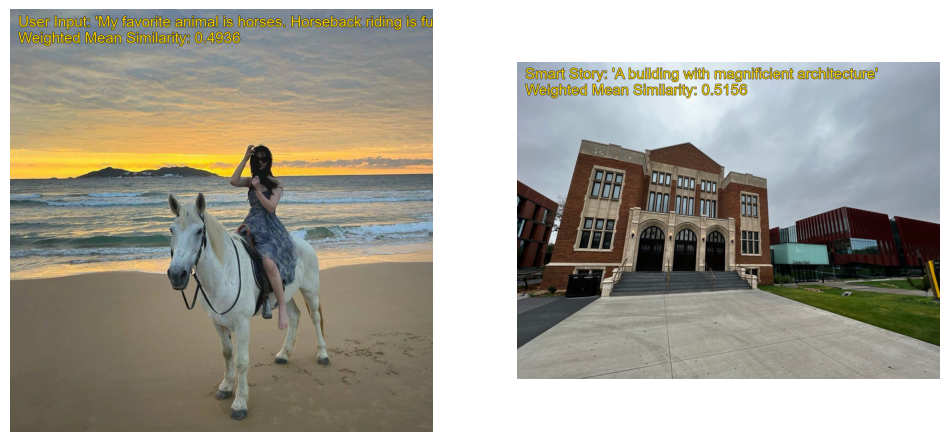

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def display_image_with_overlay(image_path, text_source, similarity_score):
    # Load the image
    image = Image.open(image_path)
    
    # Initialize drawing context
    draw = ImageDraw.Draw(image)
    
    # Font settings
    try:
        # Attempt to use a specific font if available
        font = ImageFont.truetype("arial.ttf", 36)
    except IOError:
        # Fallback to default font if specific font is not found
        font = ImageFont.load_default()
        
    # Define the text to overlay
    text = f"{text_source}\nWeighted Mean Similarity: {similarity_score:.4f}"
    
    # Position for the text (adjust as needed)
    text_position = (20, 10)

    # Draw text on the image
    draw.text(text_position, text, font=font, fill="gold", stroke_width=1, stroke_fill='black')
    
    return image

# Find the images with the highest mean similarity scores
most_similar_image_user = max(user_weighted_mean_similarities, key=user_weighted_mean_similarities.get)
most_similar_image_desc = max(story_weighted_mean_similarities, key=story_weighted_mean_similarities.get)

# Scores for the most similar images
score_user = user_weighted_mean_similarities[most_similar_image_user]
score_smart_story = story_weighted_mean_similarities[most_similar_image_desc]

# Defining the image paths
user_input_image_path = f"{BASE_DIR}/exported/{most_similar_image_user}".replace(".JPG", ".jpg")
smart_story_image_path = f"{BASE_DIR}/exported/{most_similar_image_desc}".replace(".JPG", ".jpg")

# Display images with overlays using the updated function
user_input_image = display_image_with_overlay(user_input_image_path, f"User Input: '{user_text_prompt}'", score_user)
smart_story_image = display_image_with_overlay(smart_story_image_path, f"Smart Story: '{smart_story_description}'", score_smart_story)

# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(user_input_image)
ax[0].axis('off')  # Hide the axis
ax[1].imshow(smart_story_image)
ax[1].axis('off')  # Hide the axis
plt.show()


### END!